# **Dynamic Reorder Point Optimization Project(predicting Reorder Point)**

## **Install & Import Libraries**

In [1]:
# Step 1: Install & Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix

In [2]:
# Optional: set plot style
sns.set(style="whitegrid")  # apply whitegrid style for seaborn plots

## **Load Data**

In [3]:
#Step 2: Load data
demand_df = pd.read_csv("/content/demand_forecasting.csv")
inventory_df = pd.read_csv("/content/inventory_monitoring.csv")

In [4]:
demand_df

,Product ID,Date,Store ID,Sales Quantity,Price,Promotions,Seasonality Factors,External Factors,Demand Trend,Customer Segments
0,4277,2024-01-03,48,330,24.38,No,Festival,Competitor Pricing,Increasing,Regular
1,5540,2024-04-29,10,334,74.98,Yes,Holiday,Weather,Stable,Premium
2,5406,2024-01-11,67,429,24.83,Yes,Holiday,Economic Indicator,Decreasing,Premium
3,5617,2024-04-04,17,298,13.41,No,NaN,Economic Indicator,Stable,Regular
4,3480,2024-12-14,33,344,94.96,Yes,Festival,Weather,Increasing,Regular
...,...,...,...,...,...,...,...,...,...,...
9995,6545,2024-11-26,54,47,47.12,No,NaN,Competitor Pricing,Decreasing,Budget
9996,4341,2024-04-08,82,59,65.11,No,Festival,NaN,Increasing,Budget
9997,8679,2024-02-16,55,481,59.97,No,Holiday,Economic Indicator,Stable,Premium
9998,6281,2024-02-15,97,142,48.70,No,Festival,NaN,Decreasing,Regular


In [5]:
inventory_df

,Product ID,Store ID,Stock Levels,Supplier Lead Time (days),Stockout Frequency,Reorder Point,Expiry Date,Warehouse Capacity,Order Fulfillment Time (days)
0,9286,16,700,10,14,132,2024-01-15,1052,6
1,2605,60,82,11,1,127,2024-12-16,1262,9
2,2859,55,145,25,14,192,2024-04-30,1457,12
3,2374,24,151,17,6,19,2024-12-16,2944,3
4,7678,5,714,12,2,21,2024-08-05,3739,7
...,...,...,...,...,...,...,...,...,...
9995,9337,27,860,27,19,96,2024-04-30,4025,12
9996,5907,90,282,25,19,173,2024-03-18,4983,2
9997,6159,7,352,4,6,123,2024-04-23,3517,13
9998,1564,14,325,10,14,153,2024-06-24,4868,1


In [6]:
demand_df['Date'] = pd.to_datetime(demand_df['Date'])
inventory_df['Expiry Date'] = pd.to_datetime(inventory_df['Expiry Date'])

In [7]:
# Create unique combinations
demand_keys = set(zip(demand_df["Product ID"], demand_df["Store ID"]))
inventory_keys = set(zip(inventory_df["Product ID"], inventory_df["Store ID"]))

# Check how many combinations match
matching_keys = demand_keys.intersection(inventory_keys)
print(f"Matching combinations: {len(matching_keys)}")


Matching combinations: 121


In [8]:
# Create sets of unique keys
product_store_demand = set(zip(demand_df["Product ID"], demand_df["Store ID"]))
product_store_inventory = set(zip(inventory_df["Product ID"], inventory_df["Store ID"]))

# Matching keys when merging on BOTH Product ID + Store ID
matching_keys_both = product_store_demand & product_store_inventory
print(f"🔗 Matching rows on [Product ID + Store ID]: {len(matching_keys_both)}")

# Merge on BOTH keys
merge_both = pd.merge(demand_df, inventory_df, on=["Product ID", "Store ID"])
print(f"📏 Merge on BOTH keys: {merge_both.shape[0]} rows")

# Merge on only Product ID
merge_product = pd.merge(demand_df, inventory_df, on="Product ID")
print(f"📏 Merge on only Product ID: {merge_product.shape[0]} rows")

# Check for duplicate or mismatched Store IDs in the product-only merge
store_match_rate = (merge_product["Store ID_x"] == merge_product["Store ID_y"]).mean()
print(f"✅ Store ID match rate in Product-ID-only merge: {store_match_rate:.2%}")


🔗 Matching rows on [Product ID + Store ID]: 121
📏 Merge on BOTH keys: 122 rows
📏 Merge on only Product ID: 11375 rows
✅ Store ID match rate in Product-ID-only merge: 1.07%


In [9]:
# Merge data on 'Product ID' only
merged_df = pd.merge(demand_df, inventory_df, on="Product ID")

In [10]:
# Preview structure
merged_df

,Product ID,Date,Store ID_x,Sales Quantity,Price,Promotions,Seasonality Factors,External Factors,Demand Trend,Customer Segments,Store ID_y,Stock Levels,Supplier Lead Time (days),Stockout Frequency,Reorder Point,Expiry Date,Warehouse Capacity,Order Fulfillment Time (days)
0,4277,2024-01-03,48,330,24.38,No,Festival,Competitor Pricing,Increasing,Regular,44,10,4,10,19,2024-04-15,1504,8
1,5540,2024-04-29,10,334,74.98,Yes,Holiday,Weather,Stable,Premium,81,966,29,0,12,2024-07-21,4959,7
2,5540,2024-04-29,10,334,74.98,Yes,Holiday,Weather,Stable,Premium,20,73,9,1,169,2024-02-23,2964,6
3,5406,2024-01-11,67,429,24.83,Yes,Holiday,Economic Indicator,Decreasing,Premium,89,296,2,10,128,2024-11-28,3169,6
4,5617,2024-04-04,17,298,13.41,No,NaN,Economic Indicator,Stable,Regular,30,807,26,17,195,2024-11-20,3533,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11370,6545,2024-11-26,54,47,47.12,No,NaN,Competitor Pricing,Decreasing,Budget,68,223,13,13,127,2024-05-26,2244,12
11371,6545,2024-11-26,54,47,47.12,No,NaN,Competitor Pricing,Decreasing,Budget,76,7,6,4,42,2024-04-12,2432,6
11372,4341,2024-04-08,82,59,65.11,No,Festival,NaN,Increasing,Budget,49,766,15,4,125,2024-01-30,1223,14
11373,6281,2024-02-15,97,142,48.70,No,Festival,NaN,Decreasing,Regular,96,125,13,9,146,2024-04-09,2325,12


📦 **1. Demand Forecasting (demand_forecasting.csv)**

| Column Name             | Description                            |
|-------------------------|----------------------------------------|
| Product ID, Store ID    | Product and store identifiers          |
| Date                    | Transaction date                       |
| Sales Quantity          | Number of units sold                   |
| Price, Promotions       | Price and promotion info               |
| Seasonality Factors     | Holidays, festivals, etc.              |
| External Factors        | Weather, competition, economy          |
| Demand Trend            | Increasing, Stable, Decreasing         |
| Customer Segments       | Regular, Premium, etc.                 |


**🗃️ 2. Inventory Monitoring (inventory_monitoring.csv)**

| Column Name                  | Description                            |
|------------------------------|----------------------------------------|
| Stock Levels                 | Current stock per product/store        |
| Supplier Lead Time (days)    | Avg days supplier takes to deliver     |
| Stockout Frequency           | How often the item runs out            |
| Reorder Point, Expiry Date   | Reordering and expiration info         |
| Warehouse Capacity           | How much space is available            |
| Order Fulfillment Time (days)| Time to complete an order              |


In [11]:
# Preview structure
merged_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11375 entries, 0 to 11374
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Product ID                     11375 non-null  int64         
 1   Date                           11375 non-null  datetime64[ns]
 2   Store ID_x                     11375 non-null  int64         
 3   Sales Quantity                 11375 non-null  int64         
 4   Price                          11375 non-null  float64       
 5   Promotions                     11375 non-null  object        
 6   Seasonality Factors            7634 non-null   object        
 7   External Factors               8588 non-null   object        
 8   Demand Trend                   11375 non-null  object        
 9   Customer Segments              11375 non-null  object        
 10  Store ID_y                     11375 non-null  int64         
 11  Stock Levels   

## **Visualization**

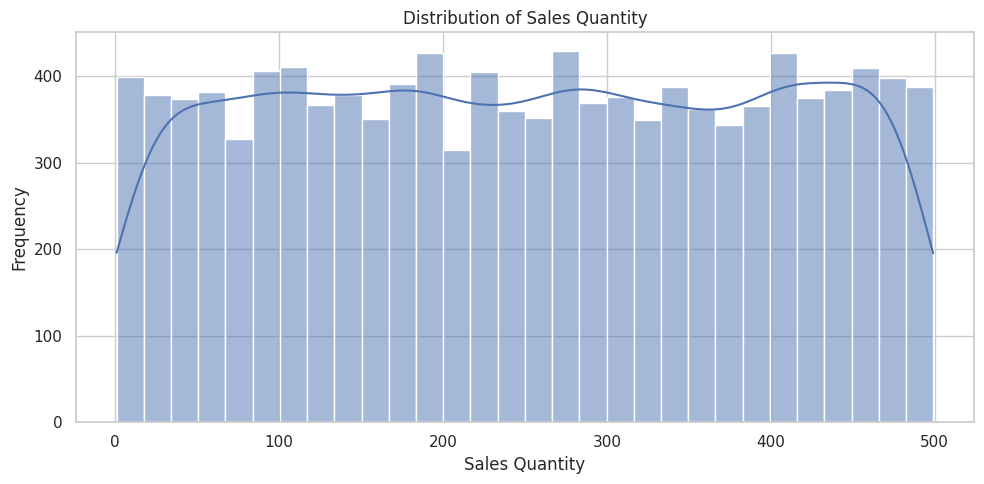

In [12]:
plt.figure(figsize=(10,5))
sns.histplot(merged_df['Sales Quantity'], bins=30, kde=True)
plt.title('Distribution of Sales Quantity')
plt.xlabel('Sales Quantity')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()  # view how demand is distributed overall

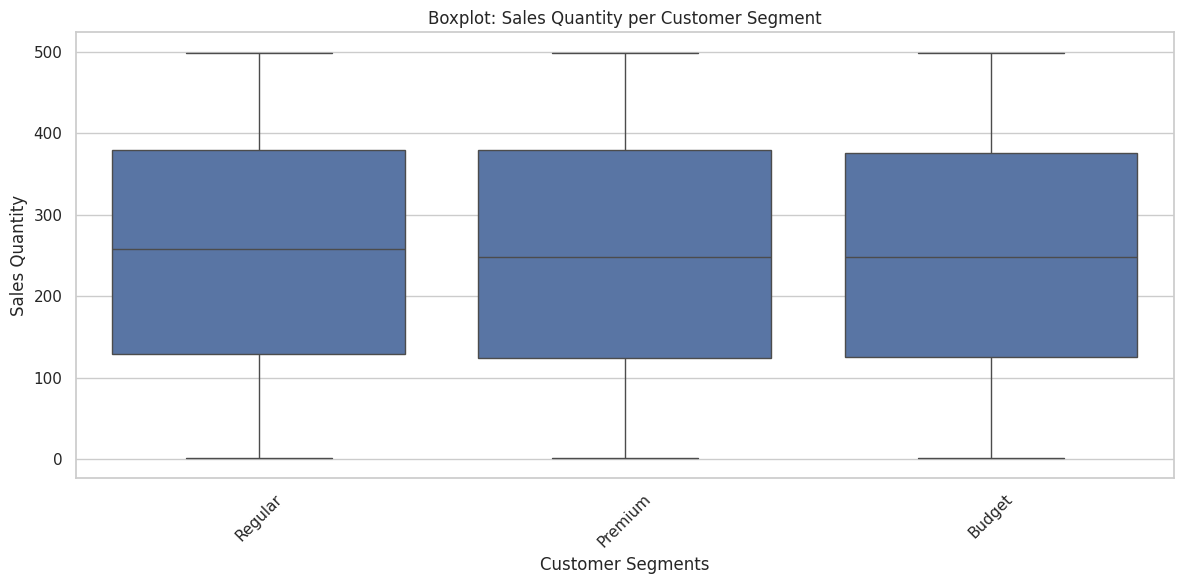

In [13]:
plt.figure(figsize=(12,6))
sns.boxplot(x='Customer Segments', y='Sales Quantity', data=merged_df)
plt.title('Boxplot: Sales Quantity per Customer Segment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()  # understand variations by customer segment

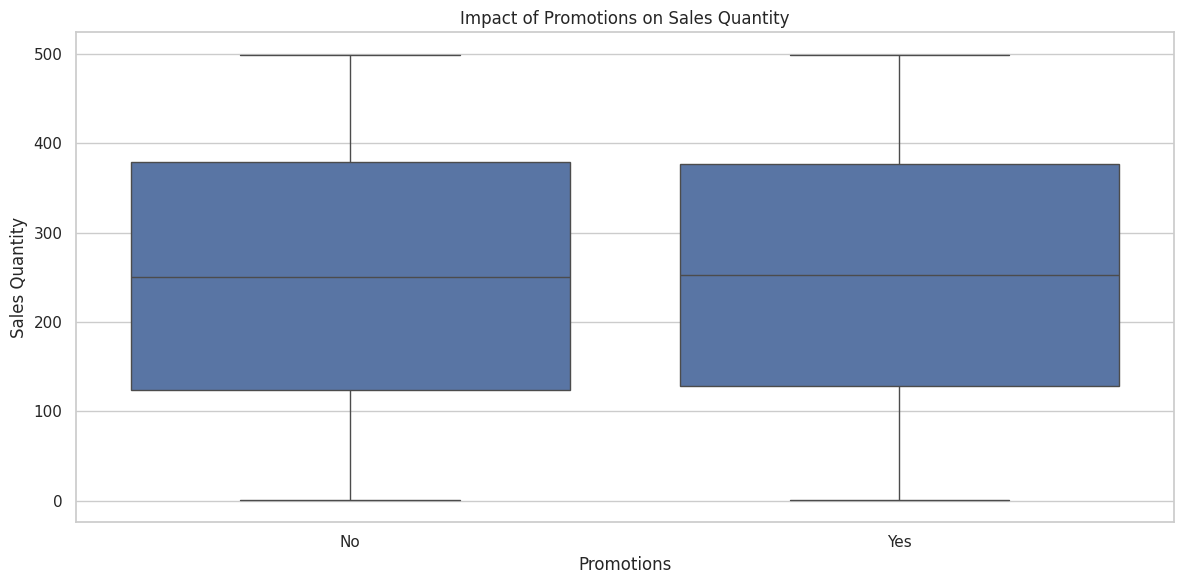

In [14]:
plt.figure(figsize=(12,6))
sns.boxplot(x='Promotions', y='Sales Quantity', data=merged_df)
plt.title('Impact of Promotions on Sales Quantity')
plt.tight_layout()
plt.show()  # assess how promotions affect sales

<ipython-input-15-bca7f4920e31>:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=merged_df, x='Seasonality Factors', y='Sales Quantity', estimator=np.mean, ci=None)


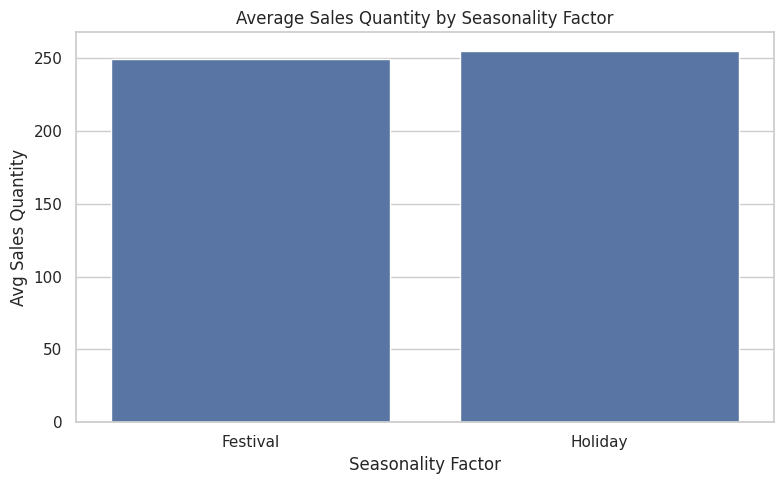

<ipython-input-15-bca7f4920e31>:12: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=merged_df, x='External Factors', y='Sales Quantity', estimator=np.mean, ci=None)


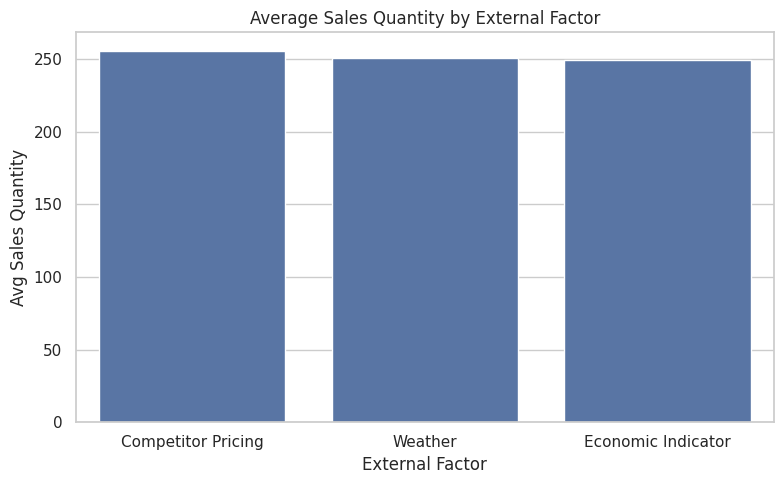

In [15]:

#barplot: average sales quantity by seasonality factor
plt.figure(figsize=(8,5))
sns.barplot(data=merged_df, x='Seasonality Factors', y='Sales Quantity', estimator=np.mean, ci=None)
plt.title('Average Sales Quantity by Seasonality Factor')
plt.ylabel('Avg Sales Quantity')
plt.xlabel('Seasonality Factor')
plt.tight_layout()
plt.show()

# barplot: average sales quantity by external factor
plt.figure(figsize=(8,5))
sns.barplot(data=merged_df, x='External Factors', y='Sales Quantity', estimator=np.mean, ci=None)
plt.title('Average Sales Quantity by External Factor')
plt.ylabel('Avg Sales Quantity')
plt.xlabel('External Factor')
plt.tight_layout()
plt.show()

## **Preprocessing and Feature Engineering**

In [16]:
#Clean and Prepare Demand Data

#Fill missing categorical values
for col in ['Seasonality Factors', 'External Factors']:
    merged_df[col] = merged_df[col].fillna('Unknown')

In [17]:
#Feature engineering
merged_df['Year'] = merged_df['Date'].dt.year
merged_df['Month'] = merged_df['Date'].dt.month
merged_df['Day'] = merged_df['Date'].dt.day
merged_df['IsWeekend'] = merged_df['Date'].dt.weekday >= 5

#Calculate demand statistics per Product ID
demand_stats = merged_df.groupby('Product ID')['Sales Quantity'].agg(
    Avg_Demand='mean',
    Demand_Std='std'
).reset_index()

# Merge stats back to merged_df
merged_df = pd.merge(merged_df, demand_stats, on='Product ID')

In [18]:
#Calculate Safety Stock and Dynamic Reorder Point
merged_df['Safety Stock'] = merged_df['Demand_Std'] * np.sqrt(merged_df['Supplier Lead Time (days)'])
merged_df['Calc Reorder Point'] = (merged_df['Avg_Demand'] * merged_df['Supplier Lead Time (days)']) + merged_df['Safety Stock']


In [19]:
# Encode categorical features
label_encoders = {}
categorical_cols = merged_df.select_dtypes(include='object').columns

for col in categorical_cols:
    le = LabelEncoder()
    merged_df[col] = le.fit_transform(merged_df[col])
    label_encoders[col] = le

# Check the result
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11375 entries, 0 to 11374
Data columns (total 26 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Product ID                     11375 non-null  int64         
 1   Date                           11375 non-null  datetime64[ns]
 2   Store ID_x                     11375 non-null  int64         
 3   Sales Quantity                 11375 non-null  int64         
 4   Price                          11375 non-null  float64       
 5   Promotions                     11375 non-null  int64         
 6   Seasonality Factors            11375 non-null  int64         
 7   External Factors               11375 non-null  int64         
 8   Demand Trend                   11375 non-null  int64         
 9   Customer Segments              11375 non-null  int64         
 10  Store ID_y                     11375 non-null  int64         
 11  Stock Levels   

In [20]:
merged_df['Product ID'].value_counts()

,count
Product ID,
7839,20
4584,20
1589,20
6081,16
9309,16
...,...
6555,1
5101,1
4268,1


In [21]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11375 entries, 0 to 11374
Data columns (total 26 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Product ID                     11375 non-null  int64         
 1   Date                           11375 non-null  datetime64[ns]
 2   Store ID_x                     11375 non-null  int64         
 3   Sales Quantity                 11375 non-null  int64         
 4   Price                          11375 non-null  float64       
 5   Promotions                     11375 non-null  int64         
 6   Seasonality Factors            11375 non-null  int64         
 7   External Factors               11375 non-null  int64         
 8   Demand Trend                   11375 non-null  int64         
 9   Customer Segments              11375 non-null  int64         
 10  Store ID_y                     11375 non-null  int64         
 11  Stock Levels   

In [31]:
#Drop rows with any missing values
merged_df = merged_df.dropna()

## **Split Data**

In [33]:
# Define features (X) and target (y)
X = merged_df.drop(columns=[
    'Date', 'Expiry Date', 'Reorder Point', 'Calc Reorder Point', 'Sales Quantity'
])
y = merged_df['Calc Reorder Point']


In [34]:
# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)


# Confirm shapes
print("X_train:", X_train.shape)
print("X_test :", X_test.shape)
print("y_train:", y_train.shape)
print("y_test :", y_test.shape)

X_train: (8115, 21)
X_test : (2029, 21)
y_train: (8115,)
y_test : (2029,)


## **Build Model**

### **Linear Regression**

In [35]:
#Train Linear Regression model
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [36]:
# Predict
y_pred_lr = lr.predict(X_test)

y_pred_lr

array([4846.92633539, 2427.05773981, 2017.05795923, ..., 6844.34479903,
       6928.97868854, 2098.1822659 ])

📊 Linear Regression Results
R² Score: 0.8965
RMSE: 929.66
Accuracy: 89.65 %


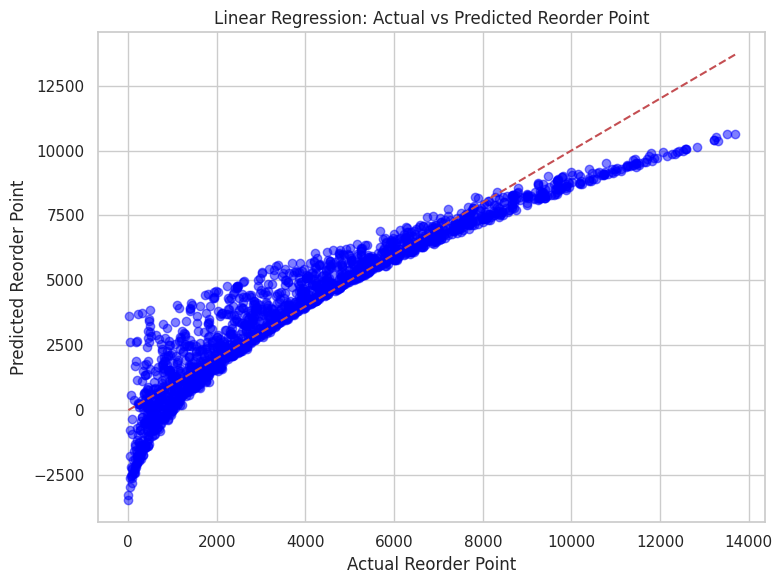

In [38]:
# Evaluate performance
print("📊 Linear Regression Results")
print("R² Score:", round(r2_score(y_test, y_pred_lr), 4))
print("RMSE:", round(mean_squared_error(y_test, y_pred_lr) ** 0.5, 2))
print("Accuracy:", round(lr.score(X_test, y_test) * 100, 2), "%")

# Visualize: Actual vs Predicted
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_lr, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Reorder Point")
plt.ylabel("Predicted Reorder Point")
plt.title("Linear Regression: Actual vs Predicted Reorder Point")
plt.tight_layout()
plt.show()

### **Random Forest**

📊 Random Forest Results
R² Score: 0.9993
RMSE: 77.3
Accuracy: 99.93 %


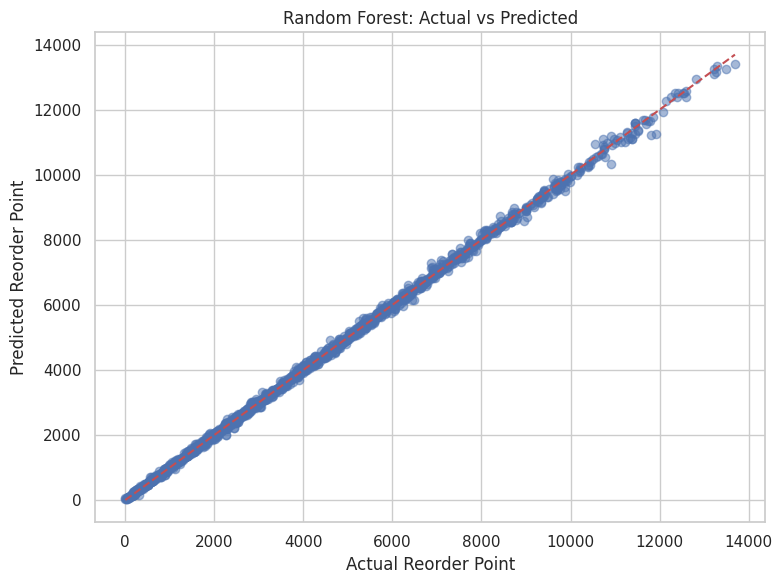

In [39]:
# Train Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict
y_pred_rf = rf.predict(X_test)

# Evaluate
print("📊 Random Forest Results")
print("R² Score:", round(r2_score(y_test, y_pred_rf), 4))
print("RMSE:", round(mean_squared_error(y_test, y_pred_rf) ** 0.5, 2))
print("Accuracy:", round(rf.score(X_test, y_test) * 100, 2), "%")

# Visualize
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Reorder Point")
plt.ylabel("Predicted Reorder Point")
plt.title("Random Forest: Actual vs Predicted")
plt.tight_layout()
plt.show()


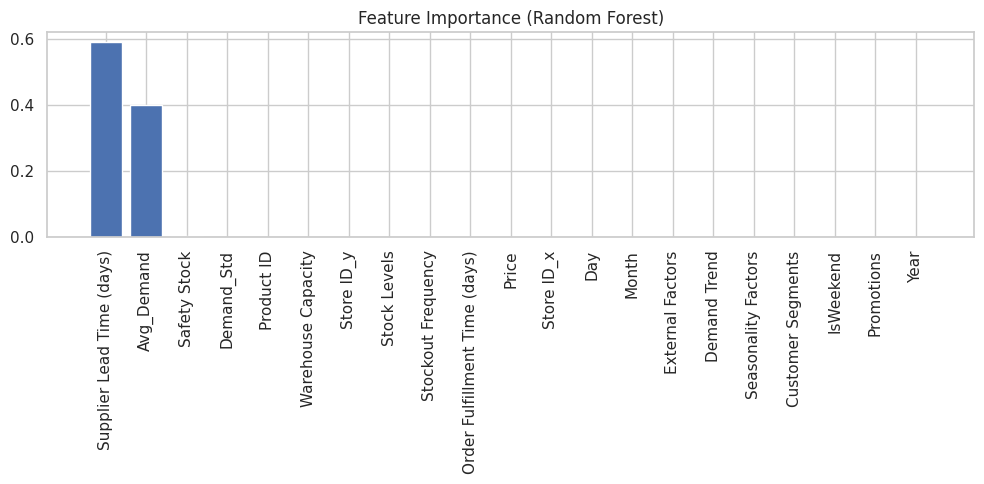

In [40]:
# Feature importances
importances = rf.feature_importances_
features = X.columns
sorted_idx = np.argsort(importances)[::-1]

# Plot
plt.figure(figsize=(10, 5))
plt.bar(range(len(importances)), importances[sorted_idx], align="center")
plt.xticks(range(len(importances)), features[sorted_idx], rotation=90)
plt.title("Feature Importance (Random Forest)")
plt.tight_layout()
plt.show()


### **Gradient Boosting**

🌟 Gradient Boosting Results
R² Score: 0.9989
RMSE: 8991.37


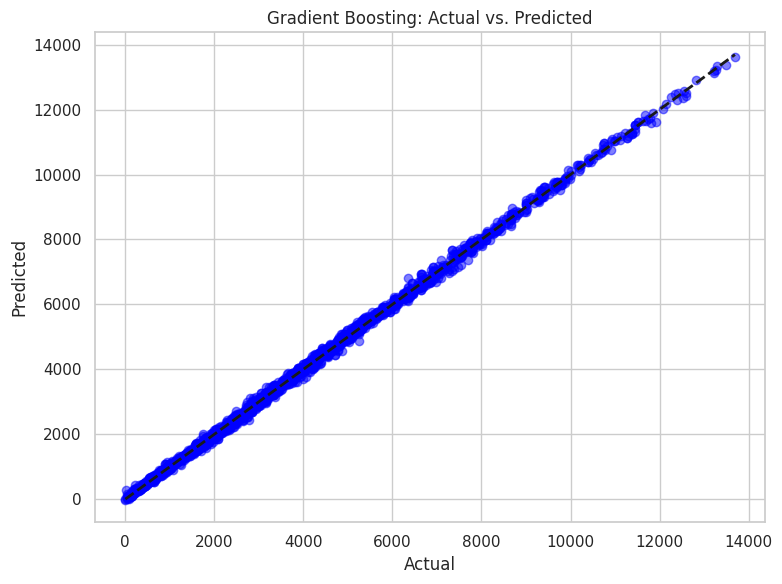

In [41]:
from sklearn.ensemble import GradientBoostingRegressor

gb = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, random_state=42)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)

#Evaluate model
r2 = r2_score(y_test, y_pred_gb)
rmse = mean_squared_error(y_test, y_pred_gb)

print("Gradient Boosting Results")
print("R² Score:", round(r2, 4))
print("RMSE:", round(rmse, 2))

#Plot Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_gb, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Gradient Boosting: Actual vs. Predicted")
plt.tight_layout()
plt.show()


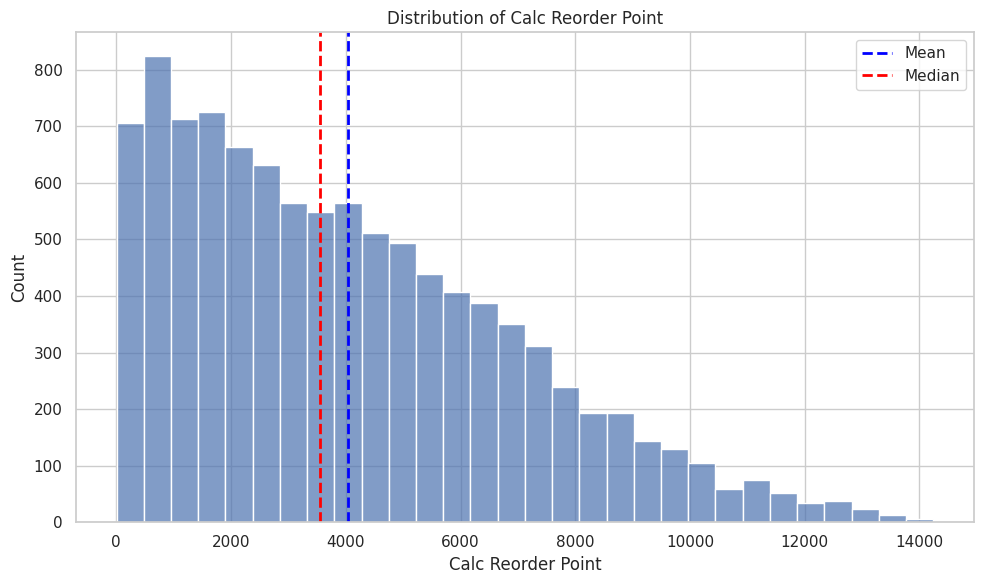

In [46]:
#Visualization - Histogram with Mean & Median
plt.figure(figsize=(10, 6))
sns.histplot(y, bins=30, kde=False, alpha=0.7)
plt.axvline(y.mean(), color='blue', linestyle='dashed', linewidth=2, label='Mean')
plt.axvline(y.median(), color='red', linestyle='dashed', linewidth=2, label='Median')
plt.title('Distribution of Calc Reorder Point')
plt.xlabel('Calc Reorder Point')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.show()

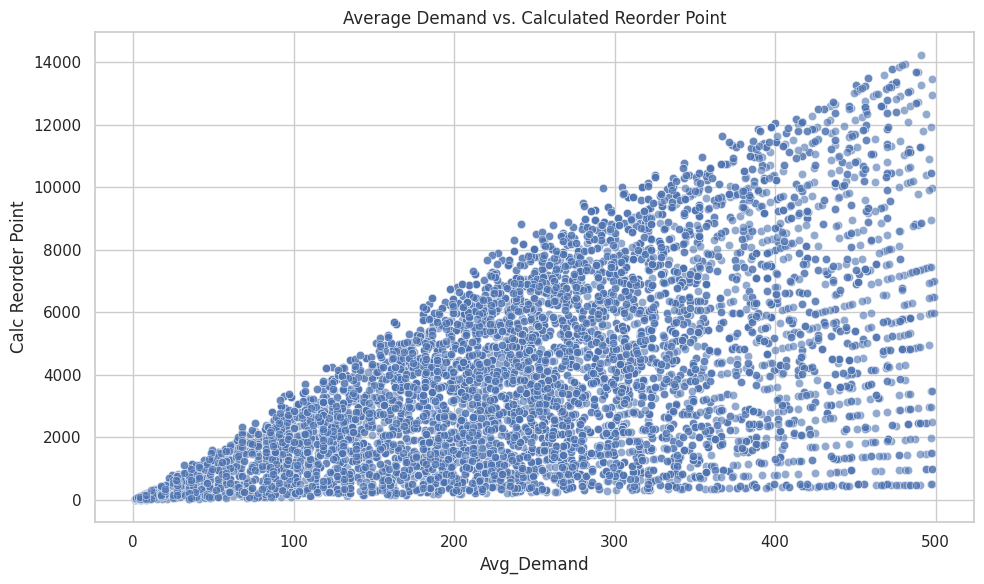

In [49]:
#Visualization - Avg Demand vs. Calc Reorder Point
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Avg_Demand', y='Calc Reorder Point', data=merged_df, alpha=0.6)
plt.title('Average Demand vs. Calculated Reorder Point')
plt.tight_layout()
plt.show()

## **Predictions and Evaluation**

In [51]:
# Compute metrics
metrics = {
    "Model": ["Linear Regression", "Random Forest", "Gradient Boosting"],
    "R² Score": [
        round(r2_score(y_test, y_pred_lr), 4),
        round(r2_score(y_test, y_pred_rf), 4),
        round(r2_score(y_test, y_pred_gb), 4)
    ],
    "RMSE": [
        round(np.sqrt(mean_squared_error(y_test, y_pred_lr)), 2),
        round(np.sqrt(mean_squared_error(y_test, y_pred_rf)), 2),
        round(np.sqrt(mean_squared_error(y_test, y_pred_gb)), 2)
    ],
    "Accuracy (%)": [
        round(lr.score(X_test, y_test) * 100, 2),
        round(rf.score(X_test, y_test) * 100, 2),
        round(gb.score(X_test, y_test) * 100, 2)
    ]
}

# Display table
results_df = pd.DataFrame(metrics)
print("\n📋 Model Comparison Summary:")
print(results_df.to_string(index=False))


📋 Model Comparison Summary:
            Model  R² Score   RMSE  Accuracy (%)
Linear Regression    0.8965 929.66         89.65
    Random Forest    0.9993  77.30         99.93
Gradient Boosting    0.9989  94.82         99.89


<ipython-input-52-eae7b48ac281>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="R² Score", data=results_df, palette="Blues_d")
<ipython-input-52-eae7b48ac281>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="RMSE", data=results_df, palette="Reds_d")
<ipython-input-52-eae7b48ac281>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="Accuracy (%)", data=results_df, palette="Greens_d")


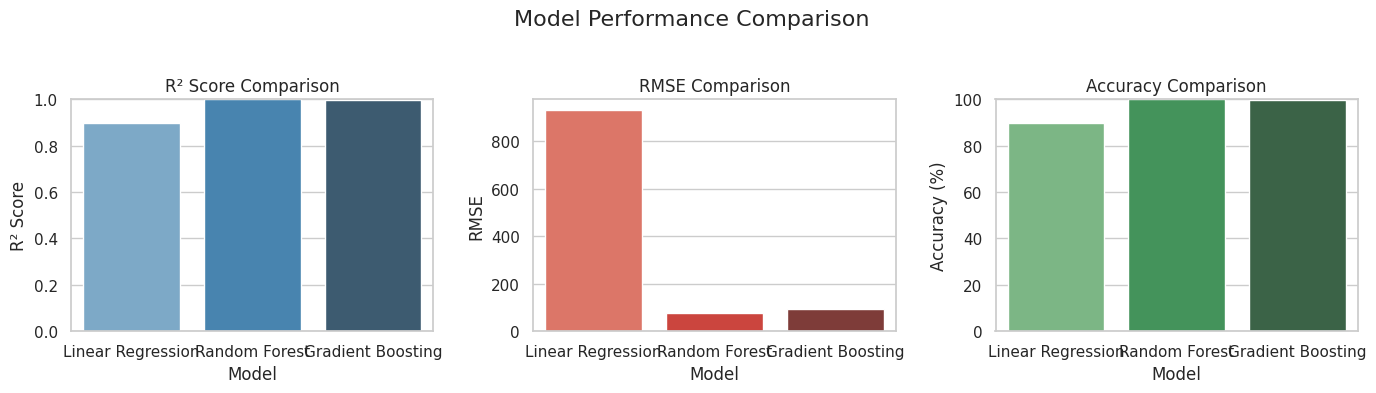

In [52]:
# 📊 Bar Chart Comparison
plt.figure(figsize=(14, 4))

# R² Score
plt.subplot(1, 3, 1)
sns.barplot(x="Model", y="R² Score", data=results_df, palette="Blues_d")
plt.title("R² Score Comparison")
plt.ylim(0, 1)

# RMSE
plt.subplot(1, 3, 2)
sns.barplot(x="Model", y="RMSE", data=results_df, palette="Reds_d")
plt.title("RMSE Comparison")

# Accuracy
plt.subplot(1, 3, 3)
sns.barplot(x="Model", y="Accuracy (%)", data=results_df, palette="Greens_d")
plt.title("Accuracy Comparison")
plt.ylim(0, 100)

plt.suptitle("Model Performance Comparison", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


## **Traditional Formula**

In [62]:

# Traditional Reorder Point = Avg_Demand × Lead Time + Safety Stock

# Step 1: Calculate Safety Stock (if not already calculated)
merged_df["Safety Stock"] = merged_df["Demand_Std"] * np.sqrt(merged_df["Supplier Lead Time (days)"])

# Step 2: Calculate Traditional Reorder Point (ROP)
merged_df["ROP_traditional"] = (
    merged_df["Avg_Demand"] * merged_df["Supplier Lead Time (days)"]
) + merged_df["Safety Stock"]

# Optional: preview result
merged_df[["Product ID", "Avg_Demand", "Supplier Lead Time (days)", "Safety Stock", "ROP_traditional"]].head()


,Product ID,Avg_Demand,Supplier Lead Time (days),Safety Stock,ROP_traditional
1,5540,334.000000,29,0.000000,9686.000000
2,5540,334.000000,9,0.000000,3006.000000
3,5406,280.333333,2,192.879928,753.546595
4,5617,298.000000,26,0.000000,7748.000000
5,5617,298.000000,28,0.000000,8344.000000


## **Visualize Differences (ML vs Traditional)**

In [63]:
# Step 2A: Build a comparison DataFrame using test set indices
comparison_df = pd.DataFrame({
    "Actual (Calc ROP)": y_test,
    "Traditional ROP": merged_df.loc[y_test.index, "ROP_traditional"],
    "RF Prediction": y_pred_rf,
    "GB Prediction": y_pred_gb,
    "LR Prediction": y_pred_lr
})

# Step 2B: Calculate absolute error between Traditional and each ML prediction
comparison_df["RF vs Traditional"] = abs(comparison_df["RF Prediction"] - comparison_df["Traditional ROP"])
comparison_df["GB vs Traditional"] = abs(comparison_df["GB Prediction"] - comparison_df["Traditional ROP"])
comparison_df["LR vs Traditional"] = abs(comparison_df["LR Prediction"] - comparison_df["Traditional ROP"])

# Step 2C: Print average error difference
print("📉 Mean Absolute Error vs Traditional Method:")
print("Random Forest:", round(comparison_df['RF vs Traditional'].mean(), 2))
print("Gradient Boosting:", round(comparison_df['GB vs Traditional'].mean(), 2))
print("Linear Regression:", round(comparison_df['LR vs Traditional'].mean(), 2))


📉 Mean Absolute Error vs Traditional Method:
Random Forest: 49.78
Gradient Boosting: 71.84
Linear Regression: 648.14


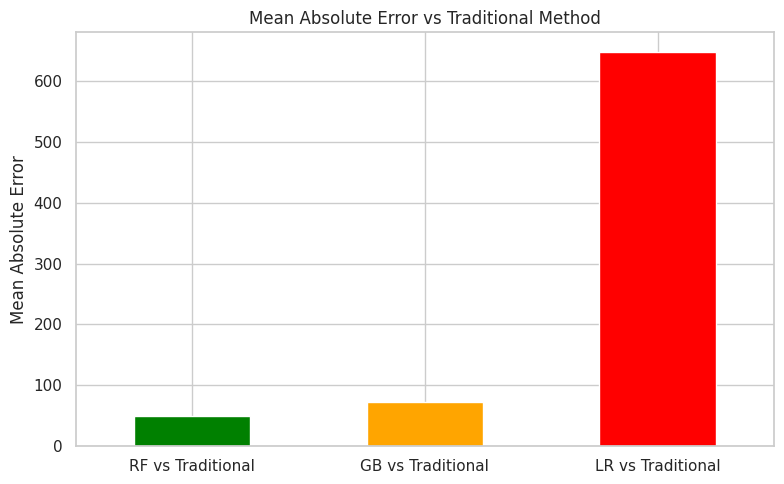

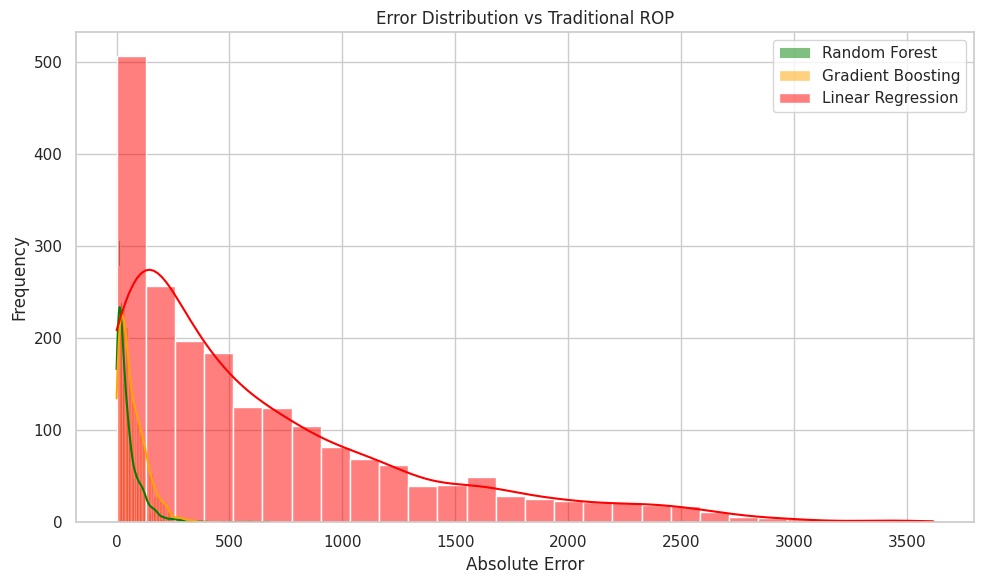

In [64]:
# 📊 Bar plot of absolute error vs traditional method
plt.figure(figsize=(8, 5))
comparison_df[["RF vs Traditional", "GB vs Traditional", "LR vs Traditional"]].mean().plot(kind='bar', color=['green', 'orange', 'red'])
plt.title("Mean Absolute Error vs Traditional Method")
plt.ylabel("Mean Absolute Error")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# 📉 Distribution of error vs Traditional
plt.figure(figsize=(10, 6))
sns.histplot(comparison_df["RF vs Traditional"], color='green', label='Random Forest', kde=True)
sns.histplot(comparison_df["GB vs Traditional"], color='orange', label='Gradient Boosting', kde=True)
sns.histplot(comparison_df["LR vs Traditional"], color='red', label='Linear Regression', kde=True)
plt.title("Error Distribution vs Traditional ROP")
plt.xlabel("Absolute Error")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()
